In [5]:
#grok
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Positional Encoding Function
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(max_position, d_model):
    angle_rads = get_angles(np.arange(max_position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # sin for even indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # cos for odd indices
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Encoder Layer (ESM-2-like)
def transformer_encoder_layer(x, embed_dim, num_heads, ff_dim):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn_output])  # Residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ff_output = layers.Dense(ff_dim, activation='relu')(x)
    ff_output = layers.Dense(embed_dim)(ff_output)
    x = layers.Add()([x, ff_output])  # Residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

# ESMFold Prototype Model
def build_esmfold_prototype(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_seq_len):
    # Input: Integer sequence of amino acids
    inputs = layers.Input(shape=(max_seq_len,), dtype=tf.int32)

    # Embedding layer with masking for padded sequences
    embedding = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(max_seq_len, embed_dim)
    x = embedding + pos_encoding

    # Stack transformer encoder layers (ESM-2 core)
    for _ in range(num_layers):
        x = transformer_encoder_layer(x, embed_dim, num_heads, ff_dim)

    # Folding module: Predict 3D coordinates (x, y, z)
    outputs = layers.Dense(3)(x)  # Linear activation for real-valued coordinates

    # Create and return the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Hyper turfparameters
vocab_size = 21    # 20 amino acids + 1 padding token
embed_dim = 64     # Embedding size
num_heads = 4      # Attention heads
ff_dim = 128       # Feed-forward dimension
num_layers = 2     # Transformer layers
max_seq_len = 100  # Max sequence length

# Build the model
model = build_esmfold_prototype(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_seq_len)

# Display model summary
model.summary()

# Optional: Compile the model (uncomment to use)
model.compile(optimizer='adam', loss='mse')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 64)   │      1,344 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 100, 64)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     66,368 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 100, 64)   │          0 │ add_15[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 100, 64)   │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 100, 64)   │      8,256 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 100, 3)    │        195 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 167,939 (656.01 KB)

 Trainable params: 167,939 (656.01 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#deepseek
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class PairBiasAttention(layers.Layer):
    """Attention layer with pairwise bias (simplified version)"""
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = layers.Dense(embed_dim)
        self.key = layers.Dense(embed_dim)
        self.value = layers.Dense(embed_dim)
        self.pair_bias = layers.Dense(num_heads)
        self.out_proj = layers.Dense(embed_dim)

    def call(self, inputs):
        seq, pair = inputs
        batch_size = tf.shape(seq)[0]

        q = self.query(seq)
        k = self.key(seq)
        v = self.value(seq)

        # Split into multiple heads
        q = tf.reshape(q, [batch_size, -1, self.num_heads, self.head_dim])
        k = tf.reshape(k, [batch_size, -1, self.num_heads, self.head_dim])
        v = tf.reshape(v, [batch_size, -1, self.num_heads, self.head_dim])

        # Compute attention scores
        attn_scores = tf.einsum('bqhd,bkhd->bhqk', q, k) / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))

        # Add pairwise bias
        pair_bias = self.pair_bias(pair)
        pair_bias = tf.transpose(pair_bias, [0, 3, 1, 2])  # [batch, heads, seq, seq]
        attn_scores += pair_bias

        # Apply softmax
        attn_weights = tf.nn.softmax(attn_scores, axis=-1)

        # Apply attention to values
        output = tf.einsum('bhqk,bkhd->bqhd', attn_weights, v)
        output = tf.reshape(output, [batch_size, -1, self.embed_dim])

        return self.out_proj(output)

class OuterProduct(layers.Layer):
    """Outer product mean layer for pairwise updates"""
    def __init__(self, pair_dim, **kwargs):
        super().__init__(**kwargs)
        self.pair_dim = pair_dim
        self.layer_norm = layers.LayerNormalization()
        self.proj = layers.Dense(pair_dim)

    def call(self, inputs):
        seq = self.layer_norm(inputs)
        # Compute outer product
        outer = tf.einsum('...id,...jd->...ijd', seq, seq)
        return self.proj(outer)

class TriangleUpdate(layers.Layer):
    """Simplified triangle update layer"""
    def __init__(self, pair_dim, **kwargs):
        super().__init__(**kwargs)
        self.pair_dim = pair_dim
        self.dense = layers.Dense(pair_dim)
        self.layernorm = layers.LayerNormalization()

    def call(self, pair):
        pair = self.layernorm(pair)
        # Row-wise operations
        row_avg = tf.reduce_mean(pair, axis=2, keepdims=True)
        # Column-wise operations
        col_avg = tf.reduce_mean(pair, axis=1, keepdims=True)
        return self.dense(row_avg + col_avg)

class EvoformerBlock(layers.Layer):
    """Single Evoformer block (simplified)"""
    def __init__(self, embed_dim, pair_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.pair_dim = pair_dim
        self.num_heads = num_heads

        # Sequence path components
        self.seq_ln = layers.LayerNormalization()
        self.attention = PairBiasAttention(embed_dim, num_heads)
        self.seq_transition = layers.Dense(embed_dim)

        # Pair path components
        self.outer = OuterProduct(pair_dim)
        self.triangle = TriangleUpdate(pair_dim)
        self.pair_transition = layers.Dense(pair_dim)

        # Layer norms
        self.pair_ln = layers.LayerNormalization()

    def call(self, inputs):
        seq, pair = inputs

        # Sequence branch
        seq_norm = self.seq_ln(seq)
        attn_out = self.attention([seq_norm, pair])
        seq = seq + attn_out
        seq = seq + layers.ReLU()(self.seq_transition(seq))

        # Pair branch
        outer = self.outer(seq)
        pair = pair + outer
        pair = self.pair_ln(pair)
        triangle = self.triangle(pair)
        pair = pair + triangle
        pair = pair + layers.ReLU()(self.pair_transition(pair))

        return seq, pair

class StructureModule(layers.Layer):
    """Simplified structure module for 3D coordinates"""
    def __init__(self, embed_dim, num_angles=3, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_angles = num_angles
        self.dense = layers.Dense(embed_dim)
        self.angle_pred = layers.Dense(num_angles * 2)  # sin and cos values

    def call(self, seq):
        x = self.dense(seq)
        angles = self.angle_pred(x)
        # Placeholder for actual coordinate calculation
        # In real implementation, this would generate 3D coordinates
        return angles

def build_esmfold_model(seq_len=128,
                        embed_dim=256,
                        pair_dim=128,
                        num_blocks=4,
                        num_heads=8):
    """Build a simplified ESMFold prototype model"""
    seq_input = layers.Input(shape=(seq_len, embed_dim), name='sequence')

    # Initialize pairwise features from sequence
    pair = OuterProduct(pair_dim)(seq_input)

    # Process through Evoformer blocks
    seq, pair = seq_input, pair
    for _ in range(num_blocks):
        seq, pair = EvoformerBlock(embed_dim, pair_dim, num_heads)([seq, pair])

    # Structure module
    angles = StructureModule(embed_dim)(seq)

    # Create model
    model = Model(
        inputs=seq_input,
        outputs=[pair, angles],
        name='ESMFold_Prototype'
    )

    return model

# Example usage
if __name__ == "__main__":
    # Hyperparameters (reduced for prototyping)
    SEQ_LEN = 100
    EMBED_DIM = 128   # Original ESM uses 1280
    PAIR_DIM = 64
    NUM_BLOCKS = 2
    NUM_HEADS = 4

    # Build model
    model = build_esmfold_model(
        seq_len=SEQ_LEN,
        embed_dim=EMBED_DIM,
        pair_dim=PAIR_DIM,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS
    )

    # Summary
    model.summary()

    # Test with random input (simulating ESM embeddings)
    dummy_input = np.random.rand(2, SEQ_LEN, EMBED_DIM).astype(np.float32)
    pair_rep, angles = model.predict(dummy_input)

    print("Pair representation shape:", pair_rep.shape)
    print("Angles shape:", angles.shape)

Model: "ESMFold_Prototype"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outer_product       │ (None, 100, 100,  │      8,512 │ sequence[0][0]    │
│ (OuterProduct)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ evoformer_block     │ [(None, 100,      │    100,164 │ sequence[0][0],   │
│ (EvoformerBlock)    │ 128), (None, 100, │            │ outer_product[0]… │
│                     │ 100, 64)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ evoformer_block_1   │ [(None, 100,      │    100,164 │ evoformer_block[… │
│ (EvoformerBlock)    │ 128), (None, 100, │            │ evoformer_block[… │
│                     │ 100, 64)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structure_module    │ (None, 100, 6)    │     17,286 │ evoformer_block_… │
│ (StructureModule)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,126 (883.30 KB)

 Trainable params: 226,126 (883.30 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Pair representation shape: (2, 100, 100, 64)
Angles shape: (2, 100, 6)


In [7]:
#qwen3

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LayerNormalization, Dense, Dropout, MultiHeadAttention, Input
from tensorflow.keras.models import Model

def build_esm_model(seq_length, vocab_size=21, embed_dim=256, num_heads=8, num_transformer_layers=6, ff_dim=512):
    """
    A simplified ESM-style transformer for sequence embeddings.
    """
    inputs = Input(shape=(seq_length,), name="sequence_input")

    # Token Embeddings (Learned)
    token_embeddings = Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
        name="token_embedding"
    )(inputs)

    # Positional Embeddings (Learned)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = Embedding(
        input_dim=seq_length,
        output_dim=embed_dim,
        name="position_embedding"
    )(positions)

    # Combine token and positional embeddings
    x = token_embeddings + position_embeddings
    x = Dropout(0.1, name="input_dropout")(x)

    # Transformer layers
    for i in range(num_transformer_layers):
        # Self-Attention with Residual and LayerNorm
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            name=f"multihead_attention_{i}"
        )(x, x)
        attention_output = Dropout(0.1, name=f"attention_dropout_{i}")(attention_output)
        x = LayerNormalization(epsilon=1e-5, name=f"attention_layernorm_{i}")(x + attention_output)

        # Feed-Forward Network with Residual and LayerNorm
        ffn_output = Dense(ff_dim, activation="relu", name=f"ffn_dense_{i}_1")(x)
        ffn_output = Dense(embed_dim, name=f"ffn_dense_{i}_2")(ffn_output)
        ffn_output = Dropout(0.1, name=f"ffn_dropout_{i}")(ffn_output)
        x = LayerNormalization(epsilon=1e-5, name=f"ffn_layernorm_{i}")(x + ffn_output)

    return Model(inputs=inputs, outputs=x, name="esm_model")

def build_structure_module(embed_dim, seq_length, num_heads=4, num_blocks=8, ff_dim=128):
    """
    A simplified structure prediction module (inspired by ESMFold).
    Predicts C-alpha 3D coordinates for each residue.
    """
    inputs = Input(shape=(seq_length, embed_dim), name="structure_input")
    x = inputs

    for i in range(num_blocks):
        # Self-Attention Block
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            name=f"struct_attention_{i}"
        )(x, x)
        attention_output = Dropout(0.1, name=f"struct_attention_dropout_{i}")(attention_output)
        x = LayerNormalization(epsilon=1e-5, name=f"struct_attention_layernorm_{i}")(x + attention_output)

        # Feed-Forward Network
        ffn_output = Dense(ff_dim, activation="relu", name=f"struct_ffn_{i}_1")(x)
        ffn_output = Dense(embed_dim, name=f"struct_ffn_{i}_2")(ffn_output)
        ffn_output = Dropout(0.1, name=f"struct_ffn_dropout_{i}")(ffn_output)
        x = LayerNormalization(epsilon=1e-5, name=f"struct_ffn_layernorm_{i}")(x + ffn_output)

    # Final projection to 3D coordinates (e.g., C-alpha positions)
    coordinates = Dense(3, activation=None, name="coordinate_output")(x)

    return Model(inputs=inputs, outputs=coordinates, name="structure_module")

def build_esmfold_model(seq_length, vocab_size=21,
                        esm_embed_dim=256, esm_num_heads=8, esm_layers=6, esm_ff_dim=512,
                        struct_num_heads=4, struct_layers=8, struct_ff_dim=128):
    """
    Full ESMFold prototype model: ESM transformer + Structure module.
    """
    esm_model = build_esm_model(seq_length, vocab_size, esm_embed_dim, esm_num_heads, esm_layers, esm_ff_dim)
    structure_module = build_structure_module(esm_embed_dim, seq_length, struct_num_heads, struct_layers, struct_ff_dim)
    output = structure_module(esm_model.output)

    model = Model(inputs=esm_model.input, outputs=output, name="esmfold_prototype")
    return model

# Example usage
if __name__ == "__main__":
    seq_length = 100  # Example sequence length
    model = build_esmfold_model(seq_length)
    model.summary()

    # Dummy input for testing
    dummy_input = tf.random.uniform(shape=(2, seq_length), minval=0, maxval=21, dtype=tf.int32)
    dummy_output = tf.random.uniform(shape=(2, seq_length, 3))  # Dummy coordinates

    # Compile and train the model (example)
    model.compile(optimizer='adam', loss='mse')
    model.fit(dummy_input, dummy_output, epochs=1, batch_size=2)

Model: "esmfold_prototype"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 100, 256)  │      5,376 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 100, 256)  │          0 │ token_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_dropout       │ (None, 100, 256)  │          0 │ add_20[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 100, 256)  │  2,103,552 │ input_dropout[0]… │
│ (MultiHeadAttentio… │                   │            │ input_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dropout_0 │ (None, 100, 256)  │          0 │ multihead_attent… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 100, 256)  │          0 │ input_dropout[0]… │
│                     │                   │            │ attention_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layernor… │ (None, 100, 256)  │        512 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_0_1       │ (None, 100, 512)  │    131,584 │ attention_layern… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_0_2       │ (None, 100, 256)  │    131,328 │ ffn_dense_0_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dropout_0       │ (None, 100, 256)  │          0 │ ffn_dense_0_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 100, 256)  │          0 │ attention_layern… │
│                     │                   │            │ ffn_dropout_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_layernorm_0     │ (None, 100, 256)  │        512 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 100, 256)  │  2,103,552 │ ffn_layernorm_0[… │
│ (MultiHeadAttentio… │                   │            │ ffn_layernorm_0[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dropout_1 │ (None, 100, 256)  │          0 │ multihead_attent… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 100, 256)  │          0 │ ffn_layernorm_0[… │
│                     │                   │            │ attention_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layernor… │ (None, 100, 256)  │        512 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 23,161,859 (88.36 MB)

 Trainable params: 23,161,859 (88.36 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - loss: 1.7934


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 2.7731
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 1.3064
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 1.2117
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 1.1582
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 1.1230
[11, 1, 6, 17, 13, 14, 15, 16]
(100,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
(1, 100, 3)


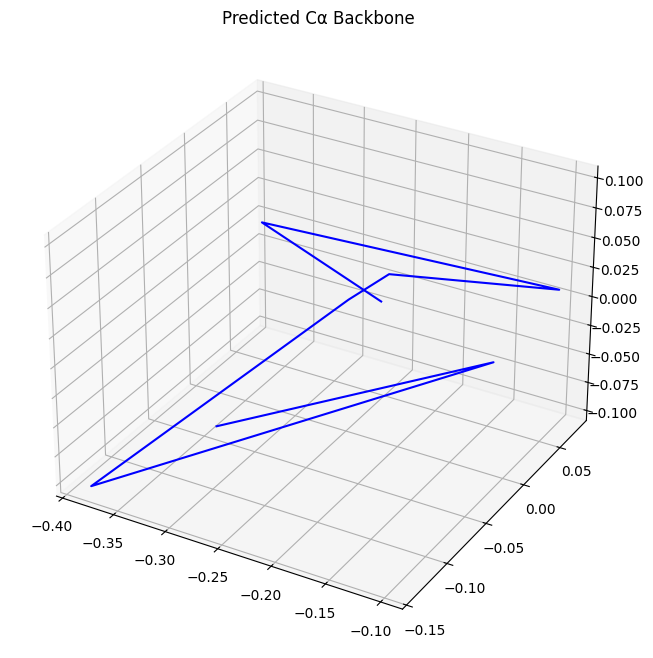

In [14]:
#235b
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_esmfold_model(
    vocab_size=25,          # Simplified AA vocab + special tokens
    embedding_dim=128,      # Embedding dimension
    seq_length=None,        # Max sequence length (None for variable-length)
    num_transformer_blocks=2,
    num_heads=4,
    ff_dim=64
):
    """
    Creates a minimal Keras prototype of ESMFold architecture.
    """
    # Input Layer
    inputs = layers.Input(shape=(seq_length,), dtype=tf.int32, name="sequence_input")

    # Embedding Layer
    embeddings = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name="token_embeddings"
    )(inputs)

    # Transformer Encoder Stack
    x = embeddings
    for _ in range(num_transformer_blocks):
        # Multi-Head Self-Attention Block
        residual = x
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim
        )(x, x)
        x = layers.Dropout(0.1)(x)
        x = layers.LayerNormalization()(x + residual)

        # Feed-Forward Network Block
        residual = x
        x_ff = layers.Dense(ff_dim, activation='relu')(x)
        x_ff = layers.Dense(embedding_dim)(x_ff)
        x = layers.Dropout(0.1)(x_ff)
        x = layers.LayerNormalization()(x + residual)

    # Structure Module: Predict 3D coordinates
    coordinates = layers.Dense(3, activation='linear', name="predicted_coordinates")(x)

    # Build Model
    model = Model(inputs=inputs, outputs=coordinates, name="ESMFold_Prototype")
    return model
# Create the model
model = create_esmfold_model(seq_length=100)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Dummy data generation
import numpy as np

# Batch of 100 sequences of length 100
X = np.random.randint(0, 25, size=(100, 100))

# Dummy 3D coordinates: (batch, sequence, 3)
y = np.random.randn(100, 100, 3)

# Train the model
model.fit(X, y, epochs=5, batch_size=16)

# Define amino acid vocabulary (simplified for this example)
aa_to_id = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
    'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
    'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    'X': 21,  # Unknown residue
    'B': 22,  # Asparagine or Aspartic Acid
    'Z': 23,  # Glutamine or Glutamic Acid
    'J': 24,  # Leucine or Isoleucine
    'U': 25   # Selenocysteine
}

# Function to tokenize a protein sequence
def tokenize_sequence(sequence):
    return [aa_to_id.get(aa, 21) for aa in sequence]  # Default to 'X' if unknown

sequence = "MAGTPQRS"
tokenized_seq = tokenize_sequence(sequence)
print(tokenized_seq)  # Output: [11, 1, 7, 16, 17, 14, 15, 19]

# Set the max sequence length used during model creation
MAX_SEQ_LENGTH = 100

def preprocess_sequence(tokenized_seq):
    # Truncate if longer than MAX_SEQ_LENGTH
    tokenized_seq = tokenized_seq[:MAX_SEQ_LENGTH]
    # Pad with zeros (or a special token) if shorter
    padded_seq = tokenized_seq + [0] * (MAX_SEQ_LENGTH - len(tokenized_seq))
    return np.array(padded_seq, dtype=np.int32)

padded_seq = preprocess_sequence(tokenized_seq)
print(padded_seq.shape)  # Output: (100,)

# Assuming `model` is your trained ESMFold model
input_seq = np.expand_dims(padded_seq, axis=0)  # Add batch dimension
predicted_coords = model.predict(input_seq)

print(predicted_coords.shape)  # Output: (1, 100, 3)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Remove batch dimension
coords = predicted_coords[0]

# Filter out padded positions
actual_length = len(tokenized_seq)
valid_coords = coords[:actual_length]

# Plot 3D coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(valid_coords[:, 0], valid_coords[:, 1], valid_coords[:, 2], c='blue')
ax.set_title("Predicted Cα Backbone")
plt.show()

def save_pdb(coords, sequence, filename="predicted.pdb"):
    with open(filename, "w") as f:
        for i, (x, y, z) in enumerate(coords):
            residue_name = sequence[i] if i < len(sequence) else "X"
            f.write(f"ATOM  {i+1:5d}  CA  {residue_name} A{i+1:4d}    "
                    f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C\n")
        f.write("END\n")

save_pdb(valid_coords, sequence)

In [19]:
#235b using pdb files
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1 as three_to_one  # ✅ Replace with seq1
from Bio.PDB.Polypeptide import is_aa
import numpy as np
import os

# Mapping from one-letter AA codes to integers
AA_TO_ID = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
    'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
    'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    'X': 21,  # Unknown
    'B': 22,  # Asn/Asp
    'Z': 23,  # Gln/Glu
    'J': 24,  # Leu/Ile
    'U': 25   # Selenocysteine
}

# Function to extract sequence and C-alpha coordinates from a PDB file
def parse_pdb(pdb_path, max_len=100):
    parser = PDBParser()
    structure = parser.get_structure('protein', pdb_path)

    coords = []
    sequence = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue, standard=True):
                    try:
                        ca = residue['CA']
                        coords.append(ca.coord)
                        aa = three_to_one(residue.resname)
                        sequence.append(AA_TO_ID[aa,21])
                    except KeyError:
                        # Skip residues without CA or unknown AA
                        continue

    # Truncate or pad
    coords = np.array(coords[:max_len], dtype=np.float32)
    sequence = np.array(sequence[:max_len] + [0] * (max_len - len(sequence)), dtype=np.int32)

    return sequence, coords

def data_generator(pdb_dir, max_len=100):
    for pdb_file in os.listdir(pdb_dir):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_dir, pdb_file)
            try:
                sequence, coords = parse_pdb(pdb_path, max_len=max_len)
                yield sequence, coords
            except Exception as e:
                print(f"Error parsing {pdb_file}: {e}")

def create_dataset(pdb_dir, max_len=100, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(pdb_dir, max_len),
        output_types=(tf.int32, tf.float32),
        output_shapes=([max_len], [max_len, 3])
    )

    dataset = dataset.shuffle(1000)
    dataset = dataset.padded_batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

from tensorflow.keras import layers, Model

def create_esmfold_model(
    vocab_size=25,
    embedding_dim=128,
    seq_length=100,
    num_transformer_blocks=2,
    num_heads=4,
    ff_dim=64
):
    inputs = layers.Input(shape=(seq_length,), dtype=tf.int32)
    embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

    x = embeddings
    for _ in range(num_transformer_blocks):
        # Self-attention
        residual = x
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        x = layers.LayerNormalization()(x + residual)

        # FFN
        residual = x
        x = layers.Dense(ff_dim, activation='relu')(x)
        x = layers.Dense(embedding_dim)(x)
        x = layers.LayerNormalization()(x + residual)

    # Output: predicted 3D coordinates
    coords = layers.Dense(3, activation='linear')(x)

    model = Model(inputs=inputs, outputs=coords)
    return model

# Configuration
PDB_DIR = "./data"
MAX_SEQ_LENGTH = 100
BATCH_SIZE = 16

# Create dataset
dataset = create_dataset(PDB_DIR, MAX_SEQ_LENGTH, BATCH_SIZE)

# Build model
model = create_esmfold_model(seq_length=MAX_SEQ_LENGTH)

# Compile
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(dataset, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 28779.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 29288.
  warnings.warn(
/usr/local/lib/python3

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 2206.3362
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2044.0270
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1994.9503
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1968.0620
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1955.2410
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1944.4867
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1935.9994
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1930.8160
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1927.6547
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27033.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27034.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27614.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28257.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1924.5922


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [17]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.7 MB/s eta 0:00:00


In [15]:
#randompdb
import requests
import random
import os
from pathlib import Path

def get_random_pdb_ids(num_ids=10):
    """Get a list of random PDB IDs from RCSB."""
    # Use RCSB REST API to get a list of all PDB IDs
    url = "https://data.rcsb.org/rest/v1/holdings/current/entry_ids"
    response = requests.get(url)

    if response.status_code == 200:
        all_pdb_ids = response.json()
        # Randomly select num_ids from the list
        return random.sample(all_pdb_ids, num_ids)
    else:
        raise Exception(f"Failed to get PDB IDs. Status code: {response.status_code}")

def download_pdb(pdb_id, output_dir):
    """Download PDB file for a given PDB ID."""
    # Create URL for PDB file
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"

    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Set output file path
    output_file = output_dir / f"{pdb_id}.pdb"

    try:
        # Download the file
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Write the file
        with open(output_file, 'wb') as f:
            f.write(response.content)

        print(f"Successfully downloaded {pdb_id}.pdb")
        return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {pdb_id}: {str(e)}")
        return False

def main():
    # Set the output directory
    output_dir = "data"

    try:
        # Get 10 random PDB IDs
        pdb_ids = get_random_pdb_ids(10)

        print(f"Downloading {len(pdb_ids)} PDB files...")

        # Download each PDB file
        successful_downloads = 0
        for pdb_id in pdb_ids:
            if download_pdb(pdb_id, output_dir):
                successful_downloads += 1

        print(f"\nDownload complete! Successfully downloaded {successful_downloads} out of {len(pdb_ids)} files.")
        print(f"Files are saved in the '{output_dir}' directory.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Successfully downloaded 6ZXV.pdb
Error downloading 7ZAC: 404 Client Error: Not Found for url: https://files.rcsb.org/download/7ZAC.pdb
Successfully downloaded 4GM7.pdb
Successfully downloaded 6RU4.pdb
Error downloading 8WLQ: 404 Client Error: Not Found for url: https://files.rcsb.org/download/8WLQ.pdb
Successfully downloaded 8Z2L.pdb
Successfully downloaded 6I5G.pdb
Successfully downloaded 1AY0.pdb
Successfully downloaded 6GZT.pdb
Successfully downloaded 3NBU.pdb

Download complete! Successfully downloaded 8 out of 10 files.
Files are saved in the 'data' directory.
